In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

import scipy.cluster.hierarchy as sch
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [2]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('./Walk_MODEL'):
    measure = pd.read_csv('./Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

(20, 170, 3)

Text(0.5, 1.0, 'f3')

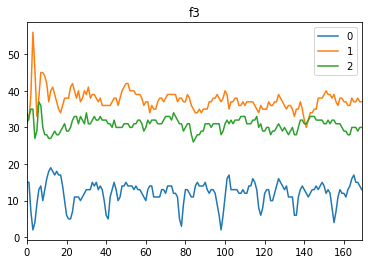

In [3]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

pd.DataFrame(data[10]).plot(legend=['X','Y','Z'])
plt.title(person_id[11])

In [4]:
### STANDARDIZE DATA ###

def std(serie): return (serie - serie.mean(axis=0))/serie.std(axis=0)
def reverse_std(serie): return serie.std(axis=0)+serie.mean(axis=0)

reverse_data = np.asarray([s.std(axis=0)+s.mean(axis=0) for s in data])
data = np.asarray([(s-s.mean(axis=0))/s.std(axis=0) for s in data])
data.shape

(20, 170, 3)

# DIMENSIONALITY REDUCTION

In [5]:
input_layer = Input(shape=(data.shape[1], 3))
encoder = TimeDistributed(Dense(200, activation='relu'))(input_layer)
encoder = TimeDistributed(Dense(50, activation="relu"))(encoder)

decoder = TimeDistributed(Dense(50, activation='relu'))(encoder)
decoder = TimeDistributed(Dense(200, activation='relu'))(decoder)

out = TimeDistributed(Dense(3))(decoder)

autoencoder = Model(inputs=input_layer, outputs=out)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 170, 3)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 170, 200)          800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 50)           10050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 170, 50)           2550      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 170, 200)          10200     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 170, 3)            603       
Total params: 24,203
Trainable params: 24,203
Non-trainable params: 0
_________________________________________________________

In [7]:
autoencoder.fit(data[:10],data[:10], epochs=100, shuffle=True, verbose=2)

Train on 10 samples
Epoch 1/100
10/10 - 1s - loss: 0.9459
Epoch 2/100
10/10 - 0s - loss: 0.9002
Epoch 3/100
10/10 - 0s - loss: 0.8559
Epoch 4/100
10/10 - 0s - loss: 0.8115
Epoch 5/100
10/10 - 0s - loss: 0.7660
Epoch 6/100
10/10 - 0s - loss: 0.7188
Epoch 7/100
10/10 - 0s - loss: 0.6703
Epoch 8/100
10/10 - 0s - loss: 0.6206
Epoch 9/100
10/10 - 0s - loss: 0.5702
Epoch 10/100
10/10 - 0s - loss: 0.5199
Epoch 11/100
10/10 - 0s - loss: 0.4704
Epoch 12/100
10/10 - 0s - loss: 0.4229
Epoch 13/100
10/10 - 0s - loss: 0.3784
Epoch 14/100
10/10 - 0s - loss: 0.3377
Epoch 15/100
10/10 - 0s - loss: 0.3012
Epoch 16/100
10/10 - 0s - loss: 0.2684
Epoch 17/100
10/10 - 0s - loss: 0.2382
Epoch 18/100
10/10 - 0s - loss: 0.2091
Epoch 19/100
10/10 - 0s - loss: 0.1799
Epoch 20/100
10/10 - 0s - loss: 0.1508
Epoch 21/100
10/10 - 0s - loss: 0.1227
Epoch 22/100
10/10 - 0s - loss: 0.0974
Epoch 23/100
10/10 - 0s - loss: 0.0764
Epoch 24/100
10/10 - 0s - loss: 0.0604
Epoch 25/100
10/10 - 0s - loss: 0.0496
Epoch 26/100
1

Text(0.5, 1.0, 'reconstruction error f3')

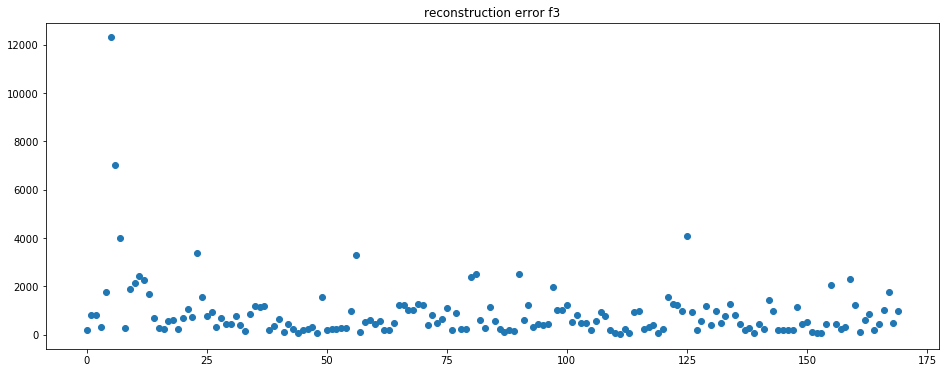

In [8]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict(data[11][np.newaxis,:,:]) * reverse_data[11]

mse = np.mean(np.power(data[11] - predictions[0], 2), axis=1)

plt.figure(figsize=(16,6))
plt.scatter(y=mse,x=range(data.shape[1]))
plt.title('reconstruction error '+person_id[11])

In [9]:
def reconstructe_error(series, reverse_data):
    
    predictions = autoencoder.predict(series[np.newaxis,:,:]) * reverse_data
    mse = np.mean(np.power(series - predictions[0], 2), axis=1)
    return mse

# Pearson Correlation CLUSTERING

(170, 10)


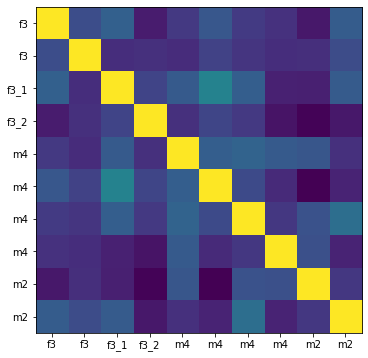

In [10]:
### COMPUTE CORRELATION MATRIX ###

df = pd.DataFrame([reconstructe_error(series,reverse) for series,reverse in zip(data[10:],reverse_data[10:])]).T
print(df.shape)

plt.figure(figsize=(6,6))
plt.imshow(df.corr())
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

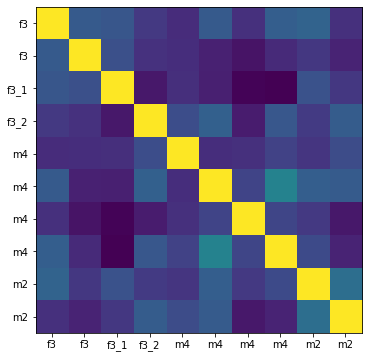

In [11]:
### HIERACHICAL CLUSTERING ###

X = df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max()*0.99, 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

plt.figure(figsize=(6,6))
plt.imshow(df.corr())
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

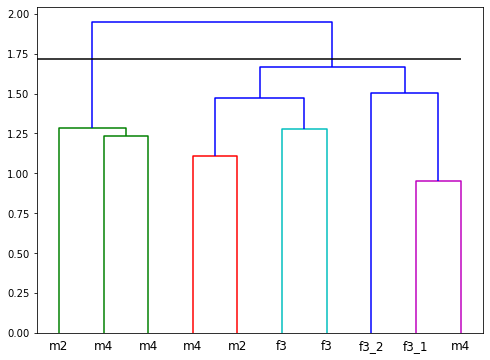

In [12]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.hlines(d.max()*0.99,0,np.max(dendrogram['icoord']))

# Kolmogorov-Smirnov CLUSTERING

(170, 10)


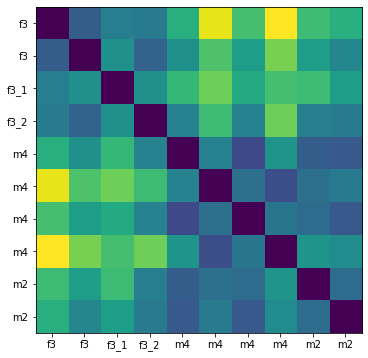

In [13]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = pd.DataFrame([reconstructe_error(series,reverse) for series,reverse in zip(data[10:],reverse_data[10:])]).T
print(df.shape)

results = []
for i in range(len(df.columns)):
    kf_test = df.apply(lambda x: stats.ks_2samp(df.iloc[:,i].values, x)[0],axis=0)
    results.append(kf_test.tolist())

plt.figure(figsize=(6,6))
plt.imshow(results)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

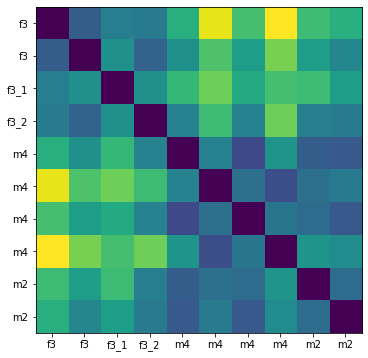

In [14]:
### HIERACHICAL CLUSTERING ###

X = np.asarray(results)
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max()*0.99, 'distance')

plt.figure(figsize=(6,6))
plt.imshow(X[:,np.argsort(ind)])
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

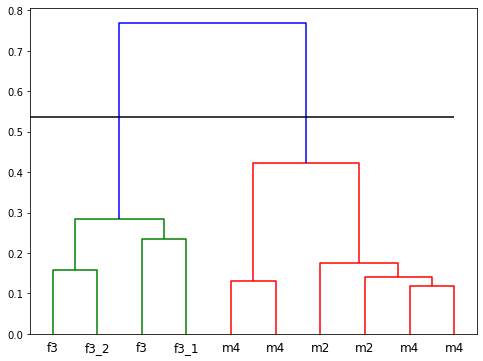

In [15]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.hlines(d.max()*0.95,0,np.max(dendrogram['icoord']))